In [1]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
from torchvision import datasets
import analysis_utils
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
n_views = 1
batch_size = 8
model_dir = "../best_cifar10"

In [3]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_cifar10.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 1
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = auto
if_profile = False

[DATA]
dataset = CIFAR10
n_views = 16
n_trans = 1
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
augmentation_package = albumentations
crop_size = [32]
crop_min_scale = [0.08]
crop_max_scale = [1.0]
hflip_prob = [0.5]
blur_kernel_size = [3]
blur_prob = [0.5]
grayscale_prob = [0.2]
jitter_brightness = [0.8]
jitter_contrast = [0.8]
jitter_saturation = [0.8]
jitter_hue = [0.2]
jitter_prob = [0.8]

[SSL]
backbone = resnet18
use_projection_head = True
proj_dim = [2048]
proj_out_dim = 256
optimizer = LARS
lr = 2.0

In [5]:
test_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=False,download=False)
aug_ops = ["ToTensor","Normalize"]
config.DATA["mean4norm"] = [0.491,0.482,0.446]
config.DATA["std4norm"] = [0.247,0.243,0.261]  
transform = data_utils.get_transform(aug_ops,aug_params=config.DATA,aug_pkg="torchvision")
test_dataset = data_utils.WrappedDataset(test_dataset,[transform],n_views = n_views,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)

In [12]:
device = torch.device("cuda:0")  # Use GPU 0
trained_filename = os.path.join(model_dir,"ssl",'ssl-epoch=999.ckpt')
if os.path.isfile(trained_filename):
    print(f'Found pretrained model at {trained_filename}, loading...')
    ssl_model = lightning_models.CLAP.load_from_checkpoint(trained_filename)
ssl_model.backbone.remove_projection_head()
backbone = ssl_model.backbone.to(device)

Found pretrained model at ../best_cifar10/ssl/ssl-epoch=999.ckpt, loading...
max_mem_size is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm


/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.4.0


In [23]:
def get_representations(backbone,test_dataset,count=2400):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)
    rep_vecs = []
    all_labels =[]
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        all_labels.append(labels[0].detach().cpu())
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(batch_size,preds.shape[-1]))
            centers = torch.mean(preds,dim=0)
            preds -= centers
            rep_vecs.append(preds)
            
    rep_vecs = torch.cat(rep_vecs,dim=0).detach().cpu().numpy()
    all_labels = torch.cat(all_labels,dim=-1).detach().cpu().numpy()
    return rep_vecs,all_labels

In [42]:
x,y = get_representations(backbone,test_dataset,count=20000)

In [52]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=800,
    random_state=0,
)
X = t_sne.fit_transform(x)

In [58]:
def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in range(10):
        pos = np.where(y==digit)
        print(X[pos].shape)
        ax.scatter(
            X[pos][:,0],X[pos][:,1],
            marker=".",
            s=30,
            color=plt.cm.tab10(digit),
            alpha=0.5,
            zorder=2,label = str(digit)
        )
    ax.set_title(title)
    ax.axis("off")
    plt.savefig("t-sne.png",bbox_inches='tight',dpi=480) 
    #ax.legend()

(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


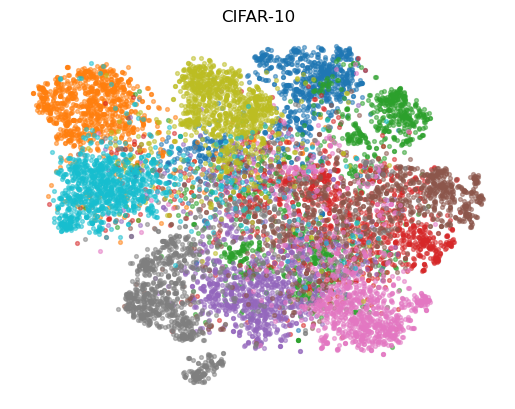

In [59]:
plot_embedding(X,"CIFAR-10")

In [41]:
t_sne = TSNE(
    n_components=3,
    perplexity=30,
    max_iter=600,
    random_state=0,
)
X = t_sne.fit_transform(x)

(1000, 2)


IndexError: index 2 is out of bounds for axis 1 with size 2

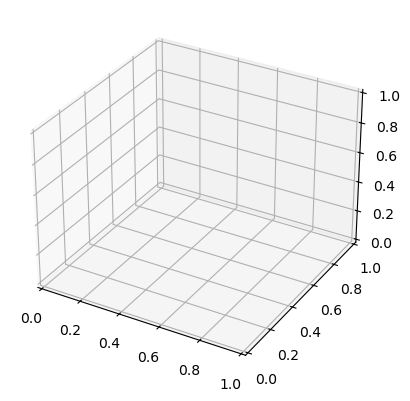